In [2]:
#!pip -q uninstall -y diffusers transformers huggingface_hub
#!pip -q install -U "huggingface_hub" "transformers" "diffusers"


In [3]:
#!pip -q install torchmetrics
#!pip -q install torch-fidelity



In [4]:
from diffusers import DDPMPipeline
from torchvision import datasets, transforms
import random, numpy as np, torch
import torch.nn as nn
import matplotlib.pyplot as plt
import copy

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# ----------------------------
# Load pretrained DDPM (CIFAR10)
# ----------------------------
pipe = DDPMPipeline.from_pretrained("google/ddpm-cifar10-32").to(device)
pipe.set_progress_bar_config(disable=True)
unet = pipe.unet.eval()

for p in unet.parameters():
    p.requires_grad_(False)

alphas_cumprod = pipe.scheduler.alphas_cumprod.to(device)  # shape [T]
T = alphas_cumprod.shape[0]

# DDPM marginal: x_t = sqrt(a_bar_t) x0 + sqrt(1-a_bar_t) eps
def add_ddpm_noise(x0, t, eps=None):
    """
    x0: (B,3,32,32) in [-1,1]
    t:  int timestep in [0, T-1]
    """
    if eps is None:
        eps = torch.randn_like(x0)
    a_bar = alphas_cumprod[t]
    mean_coeff = torch.sqrt(a_bar)
    sigma_t = torch.sqrt(1.0 - a_bar)   # <-- DDPM noise std
    x_t = mean_coeff * x0 + sigma_t * eps
    return x_t, sigma_t

def score_fn_xt(x_t, t, sigma_t=None, with_grad=False):
    if sigma_t is None:
        sigma_t = torch.sqrt(1.0 - alphas_cumprod[t])

    t_tensor = torch.full((x_t.shape[0],), int(t), device=x_t.device, dtype=torch.long)

    if with_grad:
        eps_pred = unet(x_t, t_tensor).sample          # grad flows to x_t
    else:
        with torch.no_grad():
            eps_pred = unet(x_t, t_tensor).sample

    return -(eps_pred / sigma_t)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/143M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [6]:
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda z: z*2-1),
])
cifar = datasets.CIFAR10(root="./data", train=True, download=True, transform=tfm)
loader = torch.utils.data.DataLoader(cifar, batch_size=64, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [7]:
@torch.no_grad()
def select_renyi_landmarks_stein_torch(ksd_obj, X_t, t, sigma_t, m, sigma2,
                                      use_abs=True, jitter=0.0):
    """
    Greedy Rényi-style landmark selection on a *Stein kernel* matrix H = h_p(X,X).
    If H is indefinite, use_abs=True makes the selection robust by using |H|.
    """
    n = X_t.shape[0]
    m = min(int(m), n)

    # Build Stein kernel Gram on the whole batch
    H = ksd_obj.h_p(X_t, X_t, t=t, sigma_t=sigma_t, sigma2=sigma2,
                    with_grad_score=False)   # IMPORTANT: no grad in selector

    # Symmetrize (numerics)
    H = 0.5 * (H + H.T)

    if jitter > 0:
        H = H + jitter * torch.eye(n, device=X_t.device, dtype=H.dtype)

    # Because H may be indefinite, selection based on raw H can behave oddly.
    # Using |H| is a pragmatic fix for the *selector only*.
    A = H.abs() if use_abs else H

    diag = torch.diagonal(A)
    row_sums = A.sum(dim=1)
    first = torch.argmin(row_sums).item()

    selected = [first]
    cross_sums = A[:, first].clone()

    while len(selected) < m:
        scores = 2 * cross_sums + diag
        scores[selected] = float("inf")
        nxt = torch.argmin(scores).item()
        selected.append(nxt)
        cross_sums += A[:, nxt]

    return torch.tensor(selected, device=X_t.device, dtype=torch.long)


In [8]:
import torch

@torch.no_grad()
def estimate_sigma2_median_heuristic(X_t, num_pairs=512, eps=1e-6):
    """
    Fast median heuristic for RBF bandwidth on flattened X_t.
    Returns sigma2 (variance) used in exp(-||x-y||^2 / (2*sigma2)).
    """
    B = X_t.shape[0]
    Xf = X_t.view(B, -1)

    # sample random pairs (i,j)
    i = torch.randint(0, B, (num_pairs,), device=X_t.device)
    j = torch.randint(0, B, (num_pairs,), device=X_t.device)

    diff = Xf[i] - Xf[j]
    dist2 = (diff * diff).sum(dim=1)

    med = torch.median(dist2)
    sigma2 = 0.5 * med + eps  # common choice: sigma^2 = median/2
    return float(sigma2.item())


In [19]:
class RenyiNystroemKSDTorch:
    def __init__(self, sigma2=1.0, m_fn=lambda n: int(4*np.sqrt(n)), ridge=1e-3, mc_eps=4):
        self.sigma2 = float(sigma2)
        self.m_fn = m_fn
        self.ridge = float(ridge)
        self.mc_eps = int(mc_eps)

    def h_p(self, X, Y, t, sigma_t, sigma2, with_grad_score=False):
        X_flat = X.view(X.shape[0], -1)
        Y_flat = Y.view(Y.shape[0], -1)

        grad_logpX = score_fn_xt(X, t, sigma_t, with_grad=with_grad_score).view(X.shape[0], -1)
        grad_logpY = score_fn_xt(Y, t, sigma_t, with_grad=with_grad_score).view(Y.shape[0], -1)

        diff = X_flat[:, None, :] - Y_flat[None, :, :]
        dist2 = (diff**2).sum(dim=2)
        K = torch.exp(-dist2 / (2 * sigma2))

        gram_glogp = grad_logpX @ grad_logpY.T
        gradX = -(diff / sigma2) * K[:, :, None]
        gradY = -gradX

        B = (gradX * grad_logpY[None, :, :]).sum(dim=2)
        C = (gradY * grad_logpX[:, None, :]).sum(dim=2)

        d = X_flat.shape[1]
        gradXY_sum = (dist2 / (sigma2**2) - d / sigma2) * K

        return K * gram_glogp + B + C + gradXY_sum

    @torch.no_grad()
    def _stabilize_Hmm(self, H_mm, ridge, device):
        H_mm = 0.5 * (H_mm + H_mm.T)
        I = torch.eye(H_mm.shape[0], device=device, dtype=H_mm.dtype)
        min_eig = torch.linalg.eigvalsh(H_mm).min()
        shift = (-min_eig).clamp(min=0.0)
        return H_mm + (shift + float(ridge)) * I

    def compute_stein_discrepancy_two_sample_with_landmarks(
        self, X_real_t, X_fake_t, t, sigma_t, Z_m,
        ridge=None, sigma2=None,
        with_grad_score_fake=True
    ):
        """
        Two-sample Stein discrepancy with fixed landmarks:
            delta = beta_fake - beta_real
            stat  = delta^T (H_mm_reg^{-1}) delta

        Gradients flow ONLY through fake_t (generator).
        """
        if ridge is None: ridge = self.ridge
        if sigma2 is None: sigma2 = self.sigma2

        # Do NOT backprop through real or landmarks
        X_real_t = X_real_t.detach()
        Z_m = Z_m.detach()

        n_r = X_real_t.shape[0]
        n_f = X_fake_t.shape[0]
        assert n_r > 0 and n_f > 0

        # H_mm from landmarks only (no grad)
        H_mm = self.h_p(
            Z_m, Z_m,
            t=int(t), sigma_t=sigma_t, sigma2=float(sigma2),
            with_grad_score=False
        )
        H_mm_reg = self._stabilize_Hmm(H_mm, ridge=ridge, device=Z_m.device)

        # Cross terms
        H_mr = self.h_p(
            Z_m, X_real_t,
            t=int(t), sigma_t=sigma_t, sigma2=float(sigma2),
            with_grad_score=False
        )
        H_mf = self.h_p(
            Z_m, X_fake_t,
            t=int(t), sigma_t=sigma_t, sigma2=float(sigma2),
            with_grad_score=with_grad_score_fake
        )

        beta_real = H_mr @ (torch.ones(n_r, 1, device=Z_m.device, dtype=H_mr.dtype) / n_r)
        beta_fake = H_mf @ (torch.ones(n_f, 1, device=Z_m.device, dtype=H_mf.dtype) / n_f)

        delta = beta_fake - beta_real
        x = torch.linalg.solve(H_mm_reg, delta)
        return (delta.T @ x).squeeze()

    # ---- your ORIGINAL one-sample API (used for baseline / diagnostics) ----

    def compute_stat_from_xt_with_landmarks(
        self, X_t, t, sigma_t, Z_m,
        ridge=None, sigma2=None,
        with_grad_score=False
    ):
        if ridge is None: ridge = self.ridge
        if sigma2 is None: sigma2 = self.sigma2

        n = X_t.shape[0]
        H_mn = self.h_p(
            Z_m, X_t,
            t=int(t), sigma_t=sigma_t, sigma2=float(sigma2),
            with_grad_score=with_grad_score
        )

        H_mm = self.h_p(
            Z_m, Z_m,
            t=int(t), sigma_t=sigma_t, sigma2=float(sigma2),
            with_grad_score=False
        )
        H_mm_reg = self._stabilize_Hmm(H_mm, ridge=ridge, device=Z_m.device)

        beta = H_mn @ (torch.ones(n, 1, device=X_t.device, dtype=H_mn.dtype) / n)
        x = torch.linalg.solve(H_mm_reg, beta)
        return (beta.T @ x).squeeze()

    def _single_stat_from_xt(self, X_t, t, sigma_t, ridge, sigma2, with_grad_score=False):
        n = X_t.shape[0]
        m = min(self.m_fn(n), n)
        idx = select_renyi_landmarks_stein_torch(
            self, X_t, t=t, sigma_t=sigma_t, m=m, sigma2=sigma2, use_abs=True
        )
        Z_m = X_t[idx]
        return self.compute_stat_from_xt_with_landmarks(
            X_t=X_t, t=t, sigma_t=sigma_t, Z_m=Z_m,
            ridge=ridge, sigma2=sigma2, with_grad_score=with_grad_score
        )

    def compute_stat_from_xt(self, X_t, t, sigma_t, ridge=None, sigma2=None, with_grad_score=False):
        if ridge is None: ridge = self.ridge
        if sigma2 is None: sigma2 = self.sigma2
        return self._single_stat_from_xt(
            X_t, t=int(t), sigma_t=sigma_t,
            ridge=float(ridge), sigma2=float(sigma2),
            with_grad_score=with_grad_score
        )

    def compute_stat(self, X0, t, mc_samples=None, ridge=None, sigma2=None, bw_mode="fixed"):
        if mc_samples is None: mc_samples = self.mc_eps
        if ridge is None: ridge = self.ridge

        stats = []
        for _ in range(int(mc_samples)):
            X_t, sigma_t = add_ddpm_noise(X0, t)

            if bw_mode == "fixed":
                sigma2_eff = self.sigma2 if sigma2 is None else float(sigma2)
            elif bw_mode == "median":
                sigma2_eff = estimate_sigma2_median_heuristic(X_t)
            else:
                raise ValueError("bw_mode must be 'fixed' or 'median'")

            stats.append(self._single_stat_from_xt(
                X_t, t=int(t), sigma_t=sigma_t,
                ridge=float(ridge), sigma2=sigma2_eff,
                with_grad_score=False
            ))

        return torch.stack(stats).mean()

ksd = RenyiNystroemKSDTorch(sigma2=1.0, ridge=1e-3, mc_eps=4)
print(hasattr(ksd, "compute_stat"), hasattr(ksd, "compute_stein_discrepancy_two_sample_with_landmarks"))


True True


In [20]:
class DCGANGen(nn.Module):
    def __init__(self, z_dim=128, ngf=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2), nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf), nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.net(z)

G = DCGANGen(z_dim=128).to(device)
opt = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))


In [21]:
def estimate_real_baseline(t, num_batches=5, mc_samples=4, ridge=1e-3):
    vals = []
    it = iter(loader)
    for _ in range(num_batches):
        xr, _ = next(it)
        xr = xr.to(device)
        vals.append(ksd.compute_stat(xr, t=t, mc_samples=mc_samples, ridge=ridge).item())
    return float(np.mean(vals)), float(np.std(vals))

# Choose an initial diffusion level (not too small at first)
# (You can later anneal it downward.)
t_baseline = int(0.6 * (T - 1))
real_mean, real_std = estimate_real_baseline(t_baseline, num_batches=5)
print(f"KSD(real @ t={t_baseline}) baseline: mean={real_mean:.2f}, std={real_std:.2f}")

KSD(real @ t=599) baseline: mean=1155.31, std=125.06


In [22]:
@torch.no_grad()
def quick_eval_two_sample(G, loader, ksd, t_list, batch_size=64, z_dim=128, ridge=1e-3):
    it = iter(loader)
    real0, _ = next(it)
    real0 = real0.to(device)

    z = torch.randn(batch_size, z_dim, 1, 1, device=device)
    fake0 = G(z)

    vals = []
    for t in t_list:
        real_t, sigma_t = add_ddpm_noise(real0, int(t))
        fake_t, _       = add_ddpm_noise(fake0, int(t))

        sigma2_eff = estimate_sigma2_median_heuristic(real_t)

        m = min(ksd.m_fn(real_t.shape[0]), real_t.shape[0])
        idx = select_renyi_landmarks_stein_torch(
            ksd, real_t, t=int(t), sigma_t=sigma_t, m=m, sigma2=sigma2_eff, use_abs=True
        )
        Z_m = real_t[idx].detach()

        v = ksd.compute_stein_discrepancy_two_sample_with_landmarks(
            X_real_t=real_t,
            X_fake_t=fake_t,
            t=int(t),
            sigma_t=sigma_t,
            Z_m=Z_m,
            ridge=ridge,
            sigma2=sigma2_eff,
            with_grad_score_fake=False
        )
        vals.append(float(v.item()))
    return np.array(vals)

In [23]:
import numpy as np
import torch

def sample_t_batch(K_T, t_min, t_max, bias_to_small=False, device=None):
    """
    Returns a Python list of K_T integer timesteps in [t_min, t_max].
    If bias_to_small=True, it biases towards smaller t (harder regime).
    """
    if device is None:
        device = "cpu"

    t_min = int(t_min)
    t_max = int(t_max)
    assert 0 <= t_min <= t_max, (t_min, t_max)

    if not bias_to_small:
        # uniform integers in [t_min, t_max]
        ts = torch.randint(low=t_min, high=t_max + 1, size=(K_T,), device=device)
        return [int(x.item()) for x in ts]

    # bias towards smaller t: sample u~Uniform(0,1), take u^2 (pushes mass to 0)
    u = torch.rand(K_T, device=device)
    u = u * u
    ts = t_min + (u * (t_max - t_min)).long()
    return [int(x.item()) for x in ts]


In [24]:
import torch

def mmd2_rbf(X, Y, sigma2: float, eps: float = 1e-12):
    """
    Unbiased MMD^2 with an RBF kernel k(x,y)=exp(-||x-y||^2/(2*sigma2)).

    X: (B,3,32,32) or (B,D)
    Y: (B,3,32,32) or (B,D)
    sigma2: variance parameter (same convention as your KSD code)
    """
    # Flatten if images
    if X.dim() > 2:
        Xf = X.view(X.size(0), -1)
    else:
        Xf = X
    if Y.dim() > 2:
        Yf = Y.view(Y.size(0), -1)
    else:
        Yf = Y

    n = Xf.size(0)
    m = Yf.size(0)
    if n < 2 or m < 2:
        raise ValueError("Need at least 2 samples in each batch for unbiased MMD^2.")

    # Pairwise squared distances
    XX = torch.cdist(Xf, Xf, p=2.0) ** 2
    YY = torch.cdist(Yf, Yf, p=2.0) ** 2
    XY = torch.cdist(Xf, Yf, p=2.0) ** 2

    # RBF kernels
    Kxx = torch.exp(-XX / (2.0 * sigma2))
    Kyy = torch.exp(-YY / (2.0 * sigma2))
    Kxy = torch.exp(-XY / (2.0 * sigma2))

    # Unbiased estimate: remove diagonals for Kxx, Kyy
    Kxx_sum = (Kxx.sum() - torch.diagonal(Kxx).sum()) / (n * (n - 1) + eps)
    Kyy_sum = (Kyy.sum() - torch.diagonal(Kyy).sum()) / (m * (m - 1) + eps)
    Kxy_sum = Kxy.mean()

    mmd2 = Kxx_sum + Kyy_sum - 2.0 * Kxy_sum
    return torch.clamp(mmd2, min=0.0)


In [25]:
# ----------------------------
# Training loop: curriculum + biased sampling + forced-low-t
# ----------------------------
steps = 2000
batch_size = 64
losses = []
log_every = 50

K_T = 4
RIDGE_LAM  = 1e-3
LAMBDA_MMD = 1.0

CURRIC_STEPS = 1000

t_hi_min = int(0.70 * (T - 1))
t_hi_max = int(0.95 * (T - 1))

t_lo_min = int(0.10 * (T - 1))
t_lo_max = int(0.70 * (T - 1))

BIAS_AFTER = 600

p_low_fixed = 0.25
t_force     = int(0.10 * (T - 1))

EVAL_EVERY = 200
t_list_eval = [int(x*(T-1)) for x in [0.9, 0.7, 0.5, 0.3, 0.1, 0.05, 0.02]]

best_low_gap = float("inf")
patience = 5
pat = 0

it = iter(loader)

for i in range(steps):
    # ---- real batch ----
    try:
        real0, _ = next(it)
    except StopIteration:
        it = iter(loader)
        real0, _ = next(it)
    real0 = real0.to(device)

    # ---- fake batch ----
    z = torch.randn(batch_size, 128, 1, 1, device=device)
    fake0 = G(z)

        # ---- curriculum range ----
    # ---- curriculum range ----
    if i < CURRIC_STEPS:
        frac = i / CURRIC_STEPS
        t_min_i = int((1 - frac) * t_hi_min + frac * t_lo_min)
        t_max_i = int((1 - frac) * t_hi_max + frac * t_lo_max)
    else:
        t_min_i, t_max_i = t_lo_min, t_lo_max

    # ---- bias towards small t after some time ----
    bias_flag = (i >= BIAS_AFTER)

    t_list = sample_t_batch(K_T, t_min_i, t_max_i, bias_to_small=bias_flag, device=device)

    # ---- force low-t SAFELY (never below current floor) ----
    if np.random.rand() < p_low_fixed:
        t_list[0] = max(t_force, t_min_i)


    loss_terms = []
    for t in t_list:
        fake_t, sigma_t = add_ddpm_noise(fake0, t)
        real_t, _       = add_ddpm_noise(real0, t)

        sigma2_eff = estimate_sigma2_median_heuristic(real_t)

        # --- select landmarks from REAL only (no-grad), to prevent "gaming" the loss ---
        m = min(ksd.m_fn(real_t.shape[0]), real_t.shape[0])

        idx = select_renyi_landmarks_stein_torch(
            ksd, real_t, t=int(t), sigma_t=sigma_t, m=m, sigma2=sigma2_eff, use_abs=True
        )
        Z_m = real_t[idx].detach()

        # --- two-sample Stein discrepancy: delta = beta_fake - beta_real ---
        ksd_t = ksd.compute_stein_discrepancy_two_sample_with_landmarks(
            X_real_t=real_t,
            X_fake_t=fake_t,
            t=int(t),
            sigma_t=sigma_t,
            Z_m=Z_m,
            ridge=RIDGE_LAM,
            sigma2=sigma2_eff,
            with_grad_score_fake=True
        )

        mmd_t = mmd2_rbf(real_t, fake_t, sigma2=sigma2_eff)
        loss_terms.append(ksd_t + LAMBDA_MMD * mmd_t)

    loss = torch.stack(loss_terms).mean()

    if not torch.isfinite(loss):
        print(f"Skipping step {i} due to non-finite loss")
        continue

    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=5.0)
    opt.step()

    if (i + 1) % log_every == 0:
        print(f"Step {i+1}: t_range=[{t_min_i},{t_max_i}] bias={bias_flag} t_list={t_list} loss={loss.item():.3f}")

    # ---- quick evaluation + early stop ----
    if (i + 1) % EVAL_EVERY == 0:
        two_vals = quick_eval_two_sample(G, loader, ksd, t_list_eval)
        print("quick TWO-SAMPLE Stein:", two_vals)

        if np.any(~np.isfinite(two_vals)):
            print("Stopping: non-finite quick_eval two-sample Stein")
            break

        low_score = float(np.mean(two_vals[-2:]))  # want this to go DOWN
        if low_score < best_low_gap - 0.05:
            best_low_gap = low_score
            pat = 0
        else:
            pat += 1
        if pat >= patience:
            print(f"Early stop: low-t score not improving (best={best_low_gap:.3f})")
            break


Step 50: t_range=[669,936] bias=False t_list=[669, 857, 682, 704] loss=23.793
Step 100: t_range=[639,924] bias=False t_list=[773, 918, 872, 882] loss=23.880
Step 150: t_range=[609,911] bias=False t_list=[609, 873, 836, 903] loss=24.028
Step 200: t_range=[579,899] bias=False t_list=[749, 873, 848, 803] loss=23.647
quick TWO-SAMPLE Stein: [  24.39859772   23.70609665   28.77635574   41.563591    210.27139282
  739.93933105 2898.94140625]
Step 250: t_range=[549,886] bias=False t_list=[549, 725, 773, 782] loss=24.382
Step 300: t_range=[519,874] bias=False t_list=[519, 632, 874, 849] loss=24.653
Step 350: t_range=[489,861] bias=False t_list=[745, 633, 751, 598] loss=24.551
Step 400: t_range=[459,849] bias=False t_list=[738, 739, 694, 485] loss=23.981
quick TWO-SAMPLE Stein: [  24.36460876   24.32396126   25.00004196   40.015625    250.1728363
  775.38745117 3256.3972168 ]
Step 450: t_range=[429,836] bias=False t_list=[429, 785, 579, 509] loss=25.220
Step 500: t_range=[399,824] bias=False t_

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Discriminator (DCGAN-style) for CIFAR10 32x32
# Output: logits (no sigmoid inside; we use BCEWithLogitsLoss)
# ---------------------------------------------------------
class DCGANDis(nn.Module):
    def __init__(self, ndf=64):
        super().__init__()
        self.net = nn.Sequential(
            # (3,32,32) -> (ndf,16,16)
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf,16,16) -> (ndf*2,8,8)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2,8,8) -> (ndf*4,4,4)
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4,4,4) -> (1,1,1)
            nn.Conv2d(ndf*4, 1, 4, 1, 0, bias=False)
        )

    def forward(self, x):
        # returns logits shape (B, 1)
        return self.net(x).view(-1, 1)

# ---------------------------------------------------------
# Helper: show a small grid of samples
# ---------------------------------------------------------
@torch.no_grad()
def show_samples(G, title="samples", n=64, z_dim=128):
    G.eval()
    z = torch.randn(n, z_dim, 1, 1, device=device)
    x = G(z).detach().cpu()  # in [-1,1]
    x = (x + 1) / 2.0        # to [0,1] for plotting

    # Make a square grid
    s = int(np.sqrt(n))
    x = x[:s*s]
    grid = x.view(s, s, 3, 32, 32).permute(0, 3, 1, 4, 2).reshape(s*32, s*32, 3).numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

# ---------------------------------------------------------
# Standard GAN training loop (DCGAN-ish)
# - Same G architecture as yours
# - Adds D and trains with BCEWithLogits
# ---------------------------------------------------------
def train_standard_gan(
    G_init,
    loader,
    steps=2000,
    batch_size=64,
    z_dim=128,
    lr_g=2e-4,
    lr_d=2e-4,
    betas=(0.5, 0.999),
    d_steps=1,
    label_smooth=0.9,
    log_every=200
):
    G = copy.deepcopy(G_init).to(device)
    D = DCGANDis(ndf=64).to(device)

    optG = torch.optim.Adam(G.parameters(), lr=lr_g, betas=betas)
    optD = torch.optim.Adam(D.parameters(), lr=lr_d, betas=betas)
    bce = nn.BCEWithLogitsLoss()

    lossesG, lossesD = [], []

    it = iter(loader)
    for step in range(1, steps + 1):
        try:
            real, _ = next(it)
        except StopIteration:
            it = iter(loader)
            real, _ = next(it)

        real = real.to(device)

        # -------------------------
        # (A) Train D
        # -------------------------
        for _ in range(d_steps):
            z = torch.randn(real.size(0), z_dim, 1, 1, device=device)
            fake = G(z).detach()

            logits_real = D(real)
            logits_fake = D(fake)

            # real labels ~ 0.9, fake labels ~ 0.0
            y_real = torch.full_like(logits_real, label_smooth, device=device)
            y_fake = torch.zeros_like(logits_fake, device=device)

            lossD = bce(logits_real, y_real) + bce(logits_fake, y_fake)

            optD.zero_grad(set_to_none=True)
            lossD.backward()
            optD.step()

        # -------------------------
        # (B) Train G (tries to fool D)
        # -------------------------
        z = torch.randn(real.size(0), z_dim, 1, 1, device=device)
        fake = G(z)
        logits_fake = D(fake)

        # want D(fake)=1
        y_gen = torch.ones_like(logits_fake, device=device)
        lossG = bce(logits_fake, y_gen)

        optG.zero_grad(set_to_none=True)
        lossG.backward()
        optG.step()

        lossesD.append(lossD.item())
        lossesG.append(lossG.item())

        if step % log_every == 0:
            print(f"[GAN] step {step}/{steps} | lossD={lossD.item():.3f} | lossG={lossG.item():.3f}")

    return G.eval(), D.eval(), lossesG, lossesD


In [27]:
@torch.no_grad()
def eval_ksd_over_t_paired(
    G, loader, ksd, t_list,
    batch_size=64, z_dim=128,
    ridge=1e-2
):
    it = iter(loader)
    vals_real, vals_fake = [], []

    for t in t_list:
        real0, _ = next(it)
        real0 = real0.to(device)

        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake0 = G(z)

        real_t, sigma_t = add_ddpm_noise(real0, int(t))
        fake_t, _       = add_ddpm_noise(fake0, int(t))

        Xt = torch.cat([real_t, fake_t], dim=0)
        sigma2_eff = estimate_sigma2_median_heuristic(Xt)

        m = min(ksd.m_fn(Xt.shape[0]), Xt.shape[0])
        idx = select_renyi_landmarks_stein_torch(
            ksd, real_t, t=int(t), sigma_t=sigma_t, m=m, sigma2=sigma2_eff, use_abs=True
        )
        Z_m = real_t[idx]

        v_real = ksd.compute_stat_from_xt_with_landmarks(
            X_t=real_t, t=int(t), sigma_t=sigma_t, Z_m=Z_m,
            ridge=ridge, sigma2=sigma2_eff, with_grad_score=False
        )
        v_fake = ksd.compute_stat_from_xt_with_landmarks(
            X_t=fake_t, t=int(t), sigma_t=sigma_t, Z_m=Z_m,
            ridge=ridge, sigma2=sigma2_eff, with_grad_score=False
        )

        vals_real.append(float(v_real.item()))
        vals_fake.append(float(v_fake.item()))

    return np.array(vals_real), np.array(vals_fake)

def plot_ksd_comparison(t_list, real_mean, real_std, ksd_vals_A, label_A, ksd_vals_B, label_B):
    plt.figure(figsize=(7,4))
    plt.plot(t_list, ksd_vals_A, marker="o", label=label_A)
    plt.plot(t_list, ksd_vals_B, marker="o", label=label_B)
    plt.plot(t_list, real_mean, marker="o", label="real baseline")
    plt.fill_between(t_list, real_mean-real_std, real_mean+real_std, alpha=0.2)
    plt.gca().invert_xaxis()  # optional: show high t on left, low t on right
    plt.xlabel("t (diffusion step)")
    plt.ylabel("KSD@t (diffusion-score)")
    plt.title("KSD diagnostic across diffusion levels")
    plt.legend()
    plt.show()


[GAN] step 200/2000 | lossD=0.648 | lossG=4.997
[GAN] step 400/2000 | lossD=0.648 | lossG=4.139
[GAN] step 600/2000 | lossD=0.439 | lossG=3.559
[GAN] step 800/2000 | lossD=0.683 | lossG=2.285
[GAN] step 1000/2000 | lossD=0.711 | lossG=3.233
[GAN] step 1200/2000 | lossD=0.707 | lossG=3.297
[GAN] step 1400/2000 | lossD=0.688 | lossG=2.520
[GAN] step 1600/2000 | lossD=0.792 | lossG=2.250
[GAN] step 1800/2000 | lossD=0.572 | lossG=4.101
[GAN] step 2000/2000 | lossD=0.585 | lossG=2.661


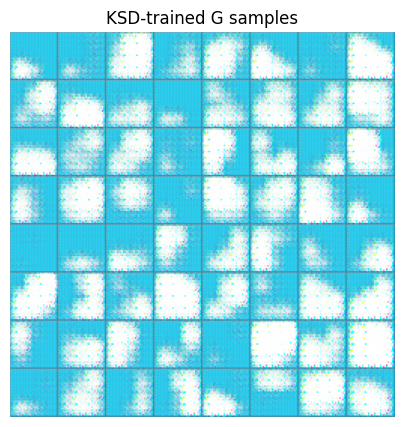

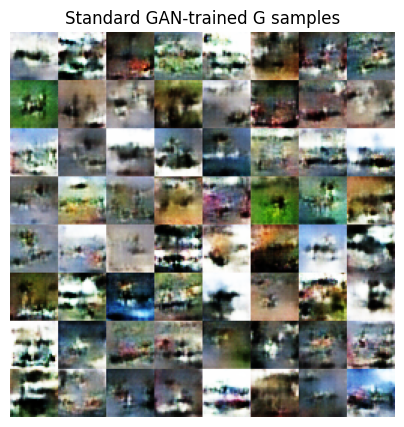

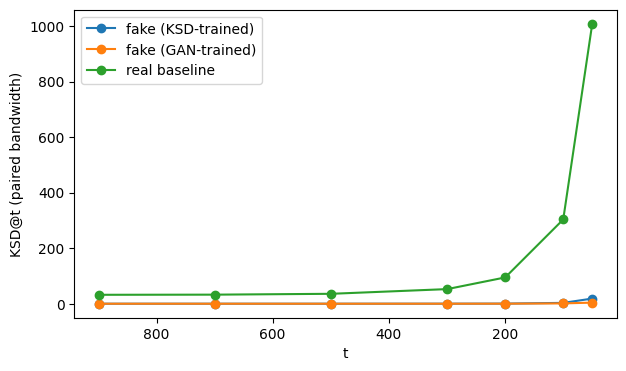

In [28]:
# 0) Keep a copy of your KSD-trained generator
G_ksd = copy.deepcopy(G).eval()

# 1) Train a standard GAN generator from scratch (same architecture)
G0 = DCGANGen(z_dim=128).to(device)  # fresh init for fair baseline
G_gan, D_gan, lossesG, lossesD = train_standard_gan(
    G_init=G0,
    loader=loader,
    steps=2000,            # start with 2k–5k; increase if stable
    batch_size=64,
    z_dim=128,
    log_every=200
)

show_samples(G_ksd, title="KSD-trained G samples")
show_samples(G_gan, title="Standard GAN-trained G samples")

# 2) Evaluate both with KSD@t
MC_SAMPLES = 8
RIDGE_LAM  = 1e-2

# IMPORTANT: don't go too low t initially (that’s where you saw explosions)
t_list = [int(x*(T-1)) for x in [0.9, 0.7, 0.5, 0.3, 0.2, 0.1, 0.05]]

real_vals_ksdG, fake_vals_ksdG = eval_ksd_over_t_paired(G_ksd, loader, ksd, t_list, ridge=1e-2)
real_vals_ganG, fake_vals_ganG = eval_ksd_over_t_paired(G_gan, loader, ksd, t_list, ridge=1e-2)

plt.figure(figsize=(7,4))
plt.plot(t_list, fake_vals_ksdG, marker="o", label="fake (KSD-trained)")
plt.plot(t_list, fake_vals_ganG, marker="o", label="fake (GAN-trained)")
plt.plot(t_list, real_vals_ksdG, marker="o", label="real baseline")
plt.gca().invert_xaxis()
plt.xlabel("t")
plt.ylabel("KSD@t (paired bandwidth)")
plt.legend()
plt.show()

